##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Probability 案例研究：协方差估计

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/TensorFlow_Probability_Case_Study_Covariance_Estimation"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/TensorFlow_Probability_Case_Study_Covariance_Estimation.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/TensorFlow_Probability_Case_Study_Covariance_Estimation.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/TensorFlow_Probability_Case_Study_Covariance_Estimation.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

此笔记本以作为学习 TensorFlow Probability 的案例研究为目的撰写而成。所选的待解决问题为估计二维零均值高斯随机变量样本的协方差矩阵。该问题有几项优势：

- 如果我们对协方差使用逆威沙特先验（一种常用方法），则问题具有解析解，因此我们可以检查所得结果。
- 该问题涉及到针对受约束参数进行采样，这适度提升了复杂性，因此更加有趣。
- 最直接的解决方案并不是最快捷的解决方案，因此需要做一些优化工作。

我决定把自身经历记录下来。在理解 TFP 的细枝末节方面，我投入了大量时间精力，此笔记本以由浅入深的方式，逐步覆盖到更加复杂的 TFP 功能。一路上，我遇到了很多问题，我试图记录能够帮助识别这些问题的过程以及最终找到的应对方法。我试图在文中包含*大量*细节（包括用于确保各步骤正确无误的大量测试）。

## 为什么要学习 TensorFlow Probability？

我发现 TensorFlow Probability 对于我的项目而言大有裨益，原因如下：

- 借助 TensorFlow Probability，您可以在笔记本中以交互方式开发复杂模型的原型。您可以将代码分解为可以执行交互式测试和单元测试的小代码段。
- 当您准备好扩大规模时，可以利用我们现有的所有基础架构，让 TensorFlow 在多台机器上的多个经优化的处理器上运行。
- 最后，虽然我真的很喜欢 Stan，但我发现其调试十分困难。您必须用一种独立语言编写所有建模代码，而鲜有可用于查看代码、检查中间状态等操作的工具。

TensorFlow Probability 的不足之处在于，它与 Stan 和 PyMC3 相比而言起步较晚，因此文档正在逐步完善，并且还有很多功能尚待构建。令人高兴的是，我发现 TFP 的基础十分坚实，它以模块化方式设计，用户可以直截了当地扩展其功能。在此笔记本中，除了解决案例研究之外，我还将展示一些扩展 TFP 的方法。

## 本文受众

此笔记本在撰写之时，假定读者满足一些重要的前提条件。您应：

- 了解贝叶斯推断的基础知识。（过您尚不了解，为您推荐一本好书：*[Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)*）
- 对马尔可夫链蒙特卡洛采样库（例如 [Stan](http://mc-stan.org/) / [PyMC3](http://docs.pymc.io/) / [BUGS](https://www.mrc-bsu.cam.ac.uk/software/bugs/)）有一定了解
- 扎实掌握  [NumPy](http://www.numpy.org/)（为您推荐一本入门好书：*[Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do)*）
- 至少对 [TensorFlow](https://tensorflow.google.cn/) 略知一二，但不必达到专业程度。（*[学习 TensorFlow](http://shop.oreilly.com/product/0636920063698.do)* 大有裨益，但是 TensorFlow 的快速进化意味着大多数书籍都会稍显过时。斯坦福的 [CS20](https://web.stanford.edu/class/cs20si/) 课程也不错。）

# 初步尝试

这是我初步尝试解决这个问题。剧透：我的解决方案不起作用，需要多次尝试才能解决问题！虽然这个过程需要一段时间，但下面的每一次尝试都会对学习 TFP 的各部分新的内容起到帮助。

一个注意事项：TFP 目前尚未实现逆威沙特分布（我们将在最后看到如何部署我们自己的逆威沙特分布），因此我将把问题改为使用威沙特先验估计精度矩阵。

In [ ]:
import collections
import math
import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## 第 1 步：将观测值汇总在一起

此处数据全部为人工合成数据，因此看起来比现实示例更加整洁。但是，您完全可以自行生成一些人工合成数据。

**提示**：一旦您决定了模型的形式，您就可以选择一些参数值并使用所选模型来生成一些人工合成数据。作为对所做实现的健全性检查，您可以验证您的估计是否包含您所选参数的真实值。为了加快调试/测试周期，您可以考虑使用简化版本的模型（例如，使用更少的维度或更小的样本量）。


**提示**：将您的观测值作为 NumPy 数组处理最为简单。需要格外注意的一点是 NumPy 默认使用 float64，而 TensorFlow 默认使用 float32。

通常，TensorFlow 运算要求所有参数都具有相同的类型，并且您必须进行显式数据强制转换才能更改类型。如果您使用 float64 观测值，则需要添加大量强制转换运算。相比之下，NumPy 会自动处理强制转换。因此，**将 Numpy 数据转换为 float32 比强制 TensorFlow 使用 float64 要*容易得多***。 

### 选择一些参数值

In [ ]:
# We're assuming 2-D data with a known true mean of (0, 0)
true_mean = np.zeros([2], dtype=np.float32)
# We'll make the 2 coordinates correlated
true_cor = np.array([[1.0, 0.9], [0.9, 1.0]], dtype=np.float32)
# And we'll give the 2 coordinates different variances
true_var = np.array([4.0, 1.0], dtype=np.float32)
# Combine the variances and correlations into a covariance matrix
true_cov = np.expand_dims(np.sqrt(true_var), axis=1).dot(
    np.expand_dims(np.sqrt(true_var), axis=1).T) * true_cor
# We'll be working with precision matrices, so we'll go ahead and compute the
# true precision matrix here
true_precision = np.linalg.inv(true_cov)

In [ ]:
# Here's our resulting covariance matrix
print(true_cov)
# Verify that it's positive definite, since np.random.multivariate_normal
# complains about it not being positive definite for some reason.
# (Note that I'll be including a lot of sanity checking code in this notebook -
# it's a *huge* help for debugging)
print('eigenvalues: ', np.linalg.eigvals(true_cov))

[[4.  1.8]
 [1.8 1. ]]
eigenvalues:  [4.843075   0.15692513]


### 生成一些人工合成观测值

请注意，**TensorFlow Probability 所用惯例为，数据的初始维度表示样本索引，数据的最终维度表示样本的维度**。

在此，我们需要 100 个样本，每个样本都是一个长度为 2 的向量。我们将生成一个形状为 (100, 2) 的数组 `my_data`。`my_data[i, :]` 是第 $i$ 个样本，它是一个长度为 2 的向量。

（请记得将 `my_data` 的类型设为 float32！）

In [ ]:
# Set the seed so the results are reproducible.
np.random.seed(123)

# Now generate some observations of our random variable.
# (Note that I'm suppressing a bunch of spurious about the covariance matrix
# not being positive semidefinite via check_valid='ignore' because it really is
# positive definite!)
my_data = np.random.multivariate_normal(
    mean=true_mean, cov=true_cov, size=100,
    check_valid='ignore').astype(np.float32)

In [ ]:
my_data.shape

(100, 2)

### 对观测值执行健全性检查

打乱人工合成数据将是一个潜在的错误来源！让我们执行一些简单的检查。

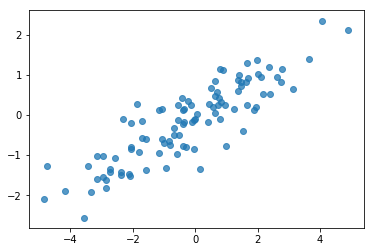

In [ ]:
# Do a scatter plot of the observations to make sure they look like what we
# expect (higher variance on the x-axis, y values strongly correlated with x)
plt.scatter(my_data[:, 0], my_data[:, 1], alpha=0.75)
plt.show()

In [ ]:
print('mean of observations:', np.mean(my_data, axis=0))
print('true mean:', true_mean)

mean of observations: [-0.24009615 -0.16638893]
true mean: [0. 0.]


In [ ]:
print('covariance of observations:\n', np.cov(my_data, rowvar=False))
print('true covariance:\n', true_cov)

covariance of observations:
 [[3.95307734 1.68718486]
 [1.68718486 0.94910269]]
true covariance:
 [[4.  1.8]
 [1.8 1. ]]


好的，我们的样本看起来很合理。下一步。

## 第 2 步：在 NumPy 中实现似然函数

为了在 TF Probability 中执行马尔可夫链蒙特卡洛采样，我们需要编写的主要内容为对数似然函数。通常，编写 TF 比 NumPy 更棘手，所以我发现在 NumPy 中进行初始实现很有帮助。我将把似然函数分成两部分，一部分为对应于 $P(data | parameters)$ 的数据似然函数，另一部分为对应于 $P(parameters)$ 的先验似然函数。

请注意，这些 NumPy 函数不必进行超级优化/矢量化，因为目标只是生成一些用于测试的值。正确性才是关键考虑要素！

首先，我们将实现数据对数似然部分，这很简单。需记住的一点是，我们将使用精度矩阵，因此我们将相应地参数化。

In [ ]:
def log_lik_data_numpy(precision, data):
  # np.linalg.inv is a really inefficient way to get the covariance matrix, but
  # remember we don't care about speed here
  cov = np.linalg.inv(precision)
  rv = scipy.stats.multivariate_normal(true_mean, cov)
  return np.sum(rv.logpdf(data))

# test case: compute the log likelihood of the data given the true parameters
log_lik_data_numpy(true_precision, my_data)

-280.81822950593767

我们将使用 Wishart 先验作为精度矩阵，因为后验有一个解析解（参见[维基百科的共轭先验表](https://en.wikipedia.org/wiki/Conjugate_prior#Continuous_distributions)）。

[威沙特分布](https://en.wikipedia.org/wiki/Wishart_distribution)具有 2 个参数：

- *自由度*的数值（在 Wikipedia 中标记为 $\nu$ ）
- *缩放矩阵*（在 Wikipedia 中标记为 $V$）

具有参数 $\nu, V$ 的威沙特分布的均值为 $E[W] = \nu V$，方差为 $\text{Var}(W_{ij}) = \nu(v_{ij}^2+v_{ii}v_{jj})$

一些有用的直觉思维：您可以通过从均值为 0 且协方差为 $V$ 的多元正态随机变量生成 $\nu$ 独立抽样  $x_1 \ldots x_{\nu}$，然后求和 $W = \sum_{i=1}^{\nu} x_i x_i^T$，从而生成威沙特样本。

如果您通过将威沙特样本除以 $\nu$ 来对其重新缩放，将获得 $x_i$ 的样本协方差矩阵。随着 $\nu$ 增大，这个样本协方差矩阵应趋向于 $V$。当 $\nu$ 较小时，样本协方差矩阵有很大的变化，因此较小的 $\nu$ 对应的先验较弱，而较大的 $\nu$ 对应的先验则较强。请注意，$\nu$ 的维度必须至少等同于所采样的空间的维度，否则您将生成奇异矩阵。

我们将使用 $\nu = 3$，因此先验较弱，我们将使用 $V = \frac{1}{\nu} I$，这会使我们的协方差估计趋向于单位矩阵（回想一下，均值为 $\nu V$）。

In [ ]:
PRIOR_DF = 3
PRIOR_SCALE = np.eye(2, dtype=np.float32) / PRIOR_DF

def log_lik_prior_numpy(precision):
  rv = scipy.stats.wishart(df=PRIOR_DF, scale=PRIOR_SCALE)
  return rv.logpdf(precision)

# test case: compute the prior for the true parameters
log_lik_prior_numpy(true_precision)

-9.103606346649766

威沙特分布是用于估计具有已知均值 $\mu$ 的多元正态的精度矩阵的共轭先验。

假设先验威沙特参数为 $\nu, V$ 并且我们有 $n$ 个多元正态观测值 $x_1, \ldots, x_n$。后验参数为 $n + \nu, \left(V^{-1} + \sum_{i=1}^n (x_i-\mu)(x_i-\mu)^T \right)^{-1}$。


In [ ]:
n = my_data.shape[0]
nu_prior = PRIOR_DF
v_prior = PRIOR_SCALE
nu_posterior = nu_prior + n
v_posterior = np.linalg.inv(np.linalg.inv(v_prior) + my_data.T.dot(my_data))
posterior_mean = nu_posterior * v_posterior
v_post_diag = np.expand_dims(np.diag(v_posterior), axis=1)
posterior_sd = np.sqrt(nu_posterior *
                       (v_posterior ** 2.0 + v_post_diag.dot(v_post_diag.T)))

后验和真实值的快速统计图。请注意，后验接近样本后验，但会稍向单位矩阵缩并。另请注意，真实值与后验模式相距甚远 - 大概这是因为先验与我们的数据匹配不佳。在实际问题中，使用诸如协方差的缩放逆威沙特先验的效果会较好（例如，请参阅 Andrew Gelman 对该主题的[评论](http://andrewgelman.com/2012/08/22/the-scaled-inverse-wishart-prior-distribution-for-a-covariance-matrix-in-a-hierarchical-model/)），但那样我们就无法获得不错的分析后验。

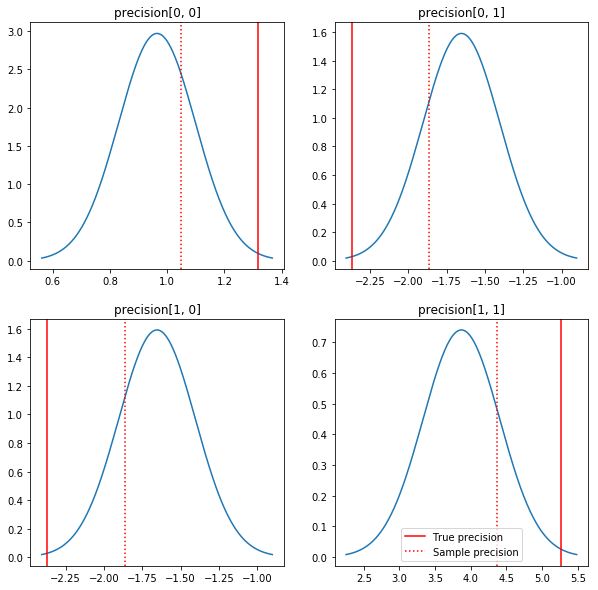

In [ ]:
sample_precision = np.linalg.inv(np.cov(my_data, rowvar=False, bias=False))
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for i in range(2):
  for j in range(2):
    ax = axes[i, j]
    loc = posterior_mean[i, j]
    scale = posterior_sd[i, j]
    xmin = loc - 3.0 * scale
    xmax = loc + 3.0 * scale
    x = np.linspace(xmin, xmax, 1000)
    y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
    ax.plot(x, y)
    ax.axvline(true_precision[i, j], color='red', label='True precision')
    ax.axvline(sample_precision[i, j], color='red', linestyle=':', label='Sample precision')
    ax.set_title('precision[%d, %d]' % (i, j))
plt.legend()
plt.show()

## 第 3 步：在 TensorFlow 中实现似然函数

剧透：我们的首次尝试并不会奏效；我们将在下面讨论原因。

**提示**：在开发似然函数时请使用 TensorFlow Eager 模式。Eager 模式会使 TF 的行为更像 NumPy - 一切都立即执行，因此您可以交互式调试，而不必使用 `Session.run()`。请参阅[此处](https://tensorflow.google.cn/programmers_guide/eager)注释。

### 准备工作：分布类

TFP 有一组分布类，我们将使用它们来生成对数概率。需要注意的一点是，这些类使用样本张量而不仅仅是单一样本 - 这样可以实现矢量化和相关加速。

分布能够以两种不同的方式处理样本张量。要说明这两种方式，例举具有单个标量参数的分布最为直观。我将使用具有 `rate` 参数的[泊松](https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/Poisson)分布。

- 如果我们使用 `rate` 参数的单个值创建泊松分布，则调用其 `sample()` 方法将返回单个值。该值称为 **`event`**，在这种情况下，事件均为标量。
- 如果我们使用 `rate` 参数的值张量创建泊松分布，则调用其 `sample()` 方法将返回多个值，速率张量中的每个值都将返回一个值。该对象充当独立泊松分布的*集合*，每个泊松分布都具有自己的速率，并且通过调用 `sample()` 返回的每个值都对应于这些泊松分布之一。这种独立*但分布不相同*的事件的集合称为 **`batch`**。
- `sample()` 方法采用 `sample_shape` 参数，该参数默认为空元组。为 `sample_shape` 传递非空值会导致样本返回多个批次。这个批次的集合称为 **`sample`**。

分布的 `log_prob()` 方法会以与 `sample()` 生成数据的方式并行的方式使用数据。`log_prob()` 返回样本的概率，即多个独立的事件批次。

- 如果我们具有以标量 `rate` 创建的泊松对象，则每个批次都为标量，如果我们传入一个样本张量，将得到一个与对数概率大小相同的张量。
- 如果我们的泊松对象是以形状为 `T` 的 `rate` 值的张量创建而成，则每个批次都将是形状为 `T` 的张量。如果我们传入形状为 D, T 的样本张量，将得到形状为 D, T 的对数概率张量。

以下几个示例可说明这些情况。有关事件、批次和形状的更详细教程，请参阅[此笔记本](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb)。


In [ ]:
# case 1: get log probabilities for a vector of iid draws from a single
# normal distribution
norm1 = tfd.Normal(loc=0., scale=1.)
probs1 = norm1.log_prob(tf.constant([1., 0.5, 0.]))

# case 2: get log probabilities for a vector of independent draws from
# multiple normal distributions with different parameters.  Note the vector
# values for loc and scale in the Normal constructor.
norm2 = tfd.Normal(loc=[0., 2., 4.], scale=[1., 1., 1.])
probs2 = norm2.log_prob(tf.constant([1., 0.5, 0.]))

print('iid draws from a single normal:', probs1.numpy())
print('draws from a batch of normals:', probs2.numpy())

iid draws from a single normal: [-1.4189385 -1.0439385 -0.9189385]
draws from a batch of normals: [-1.4189385 -2.0439386 -8.918939 ]


### 数据对数似然

首先，我们将实现数据对数似然函数。

注：分布可以验证其输入，但默认情况下不会执行验证。我们肯定希望在调试时启用验证！在一切正常的情况下，如果速度至关重要，那么我们可以关闭验证。

In [ ]:
VALIDATE_ARGS = True
ALLOW_NAN_STATS = False

与 NumPy 案例的一个主要区别是，我们的 TensorFlow 似然函数需要处理精度矩阵的向量，而不仅仅是单个矩阵。当我们从多个链采样时，将使用参数向量。

我们将创建一个处理一批精度矩阵的分布对象（即每个链一个矩阵）。

在计算数据的对数概率时，我们需要以与参数相同的方式复制数据，以便每个批次变量有一个副本。我们复制的数据的形状需采用如下形式：

`[sample shape, batch shape, event shape]`

在我们的案例中，事件形状为 2（因为我们使用的是二维高斯分布）。样本形状为 100，因为我们有 100 个样本。批次形状将仅为我们所使用的精度矩阵的数量。每次调用似然函数都复制数据十分浪费算力，因此我们会提前复制数据并传入复制版本。

请注意，这一实现效率十分低下：`MultivariateNormalFullCovariance` 相对于我们将在最后的优化部分讨论的一些替代方案而言十分消耗算力。

In [ ]:
def log_lik_data(precisions, replicated_data):
  n = tf.shape(precisions)[0]  # number of precision matrices
  # We're estimating a precision matrix; we have to invert to get log
  # probabilities.  Cholesky inversion should be relatively efficient,
  # but as we'll see later, it's even better if we can avoid doing the Cholesky
  # decomposition altogether.
  precisions_cholesky = tf.linalg.cholesky(precisions)
  covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
  rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [ ]:
# For our test, we'll use a tensor of 2 precision matrices.
# We'll need to replicate our data for the likelihood function.
# Remember, TFP wants the data to be structured so that the sample dimensions
# are first (100 here), then the batch dimensions (2 here because we have 2
# precision matrices), then the event dimensions (2 because we have 2-D
# Gaussian data).  We'll need to add a middle dimension for the batch using
# expand_dims, and then we'll need to create 2 replicates in this new dimension
# using tile.
n = 2
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
print(replicated_data.shape)

(100, 2, 2)


**提示**：我发现对 TensorFlow 函数编写少量的健全性检查极为实用。TF 中的矢量化非常容易出现问题，所以使用更简单的 NumPy 函数是验证 TF 输出的好办法。可以将这些视为小型单元测试。

In [ ]:
# check against the numpy implementation
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_data(precisions, replicated_data=replicated_data).numpy()

for i in range(n):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.8182


### 先验对数似然

由于不必担心数据复制，先验将更加容易。

In [ ]:
@tf.function(autograph=False)
def log_lik_prior(precisions):
  rv_precision = tfd.WishartTriL(
      df=PRIOR_DF,
      scale_tril=tf.linalg.cholesky(PRIOR_SCALE),
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)
  return rv_precision.log_prob(precisions)

In [ ]:
# check against the numpy implementation
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_prior(precisions).numpy()

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]))
  print('tensorflow:', lik_tf[i])

0
numpy: -2.2351873809649625
tensorflow: -2.2351875
1
numpy: -9.103606346649766
tensorflow: -9.103608


### 构建联合对数似然函数

上面的数据对数似然函数取决于我们的观测值，但采样器并不具备。我们可以通过使用[闭包](https://en.wikipedia.org/wiki/Closure_(computer_programming)来摆脱依赖而不使用全局变量。闭包涉及一个外部函数，该函数可构建包含内部函数所需变量的环境。

In [ ]:
def get_log_lik(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  @tf.function(autograph=False)
  def _log_lik(precision):
    return log_lik_data(precision, replicated_data) + log_lik_prior(precision)

  return _log_lik

## 第 4 步：采样

好的，是时候采样了！为简单起见，我们将只使用 1 个链，并以单位矩阵作为起点。我们会在后续予以细化。

再次重申，此方法并不奏效 - 我们会得到一个例外。

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  init_precision = tf.expand_dims(tf.eye(2), axis=0)

  # Use expand_dims because we want to pass in a tensor of starting values
  log_lik_fn = get_log_lik(my_data, n_chains=1)

  # we'll just do a few steps here
  num_results = 10
  num_burnin_steps = 10
  states = tfp.mcmc.sample_chain(
     num_results=num_results,
     num_burnin_steps=num_burnin_steps,
     current_state=[
         init_precision,
     ],
     kernel=tfp.mcmc.HamiltonianMonteCarlo(
         target_log_prob_fn=log_lik_fn,
         step_size=0.1,
         num_leapfrog_steps=3),
     trace_fn=None,
     seed=123)
  return states

try:
  states = sample()
except Exception as e:
  # shorten the giant stack trace
  lines = str(e).split('\n')
  print('\n'.join(lines[:5]+['...']+lines[-3:]))

 Cholesky decomposition was not successful. The input might not be valid.
	 [[{{node mcmc_sample_chain/trace_scan/while/body/_79/smart_for_loop/while/body/_371/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_537/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/StatefulPartitionedCall/Cholesky}}]] [Op:__inference_sample_2849]

Function call stack:
sample
...
Function call stack:
sample



### 确定问题

`InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.`  帮助不是很大。让我们看看能否找到关于发生的状况的更多信息。

- 我们将打印出每一步的参数，以便查看失败的值
- 我们将添加一些断言来防止出现特定问题。

断言是 TensorFlow 运算，因此较为棘手，我们必须注意确保它们会被执行并且不会在计算图外得到优化。如果您不熟悉 TF 断言，则值得阅读有关 TensorFlow 调试的[此概述](https://wookayin.github.io/tensorflow-talk-debugging/#1)。您可以使用 `tf.control_dependencies` 显式强制执行断言（请参阅下方代码中的注释）。

TensorFlow 的原生 `Print` 函数与断言具有相同的行为 - 它是一项运算，您需要注意确保其得到执行。当我们在笔记本中工作时，`Print` 会导致额外的麻烦：它的输出被发送到 `stderr`，而 `stderr` 不显示在单元格中。我们将在这里使用一个技巧：我们将通过 `tf.pyfunc` 创建自己的 TensorFlow 打印运算，而不使用 `tf.Print`。与断言一样，我们必须确保方法得到执行。


In [ ]:
def get_log_lik_verbose(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  def _log_lik(precisions):
    # An internal method we'll make into a TensorFlow operation via tf.py_func
    def _print_precisions(precisions):
      print('precisions:\n', precisions)
      return False  # operations must return something!
    # Turn our method into a TensorFlow operation
    print_op = tf.compat.v1.py_func(_print_precisions, [precisions], tf.bool)

    # Assertions are also operations, and some care needs to be taken to ensure
    # that they're executed
    assert_op = tf.assert_equal(
        precisions, tf.linalg.matrix_transpose(precisions),
        message='not symmetrical', summarize=4, name='symmetry_check')

    # The control_dependencies statement forces its arguments to be executed
    # before subsequent operations
    with tf.control_dependencies([print_op, assert_op]):
      return (log_lik_data(precisions, replicated_data) +
              log_lik_prior(precisions))

  return _log_lik

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  init_precision = tf.eye(2)[tf.newaxis, ...]
  log_lik_fn = get_log_lik_verbose(my_data)
  # we'll just do a few steps here
  num_results = 10
  num_burnin_steps = 10
  states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          init_precision,
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_lik_fn,
          step_size=0.1,
          num_leapfrog_steps=3),
      trace_fn=None,
      seed=123)

try:
  states = sample()
except Exception as e:
  # shorten the giant stack trace
  lines = str(e).split('\n')
  print('\n'.join(lines[:5]+['...']+lines[-3:]))

precisions:
 [[[1. 0.]
  [0. 1.]]]
precisions:
 [[[1. 0.]
  [0. 1.]]]
precisions:
 [[[ 0.24315196 -0.2761638 ]
  [-0.33882257  0.8622    ]]]
 assertion failed: [not symmetrical] [Condition x == y did not hold element-wise:] [x (leapfrog_integrate_one_step/add:0) = ] [[[0.243151963 -0.276163787][-0.338822573 0.8622]]] [y (leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/matrix_transpose/transpose:0) = ] [[[0.243151963 -0.338822573][-0.276163787 0.8622]]]
	 [[{{node mcmc_sample_chain/trace_scan/while/body/_96/smart_for_loop/while/body/_381/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_503/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/symmetry_check_1/Assert/AssertGuard/else/_577/Assert}}]] [Op:__inference_sample_4837]

Function call stack:
sample
...
Function call stack:
sample



### 失败原因

采样器尝试的首个新参数值是一个不对称矩阵。这会导致 Cholesky 分解失败，因为它仅针对对称（和正定）矩阵定义。

这里的问题是我们感兴趣的参数是一个精度矩阵，并且精度矩阵必须是实数、对称和正定矩阵。采样器对此约束一无所知（除非可能通过梯度得知），因此采样器完全有可能提出无效值，从而导致异常，尤其是在步长很大的情况下。

使用汉密尔顿蒙特卡洛采样器，我们可以通过使用非常小的步长来解决这个问题，因为梯度应能使参数远离无效区域，但小步长意味着收敛缓慢。如果使用对梯度一无所知的汉密尔顿蒙特卡洛采样器，那么我们将注定失败。

# 版本 2：重参数化为无约束参数

上述问题有一个简单的解决方案：我们可以重参数化模型，这样新参数就不再具有这些约束。TFP 专门为此提供了一组实用工具：双射函数。


### 使用双射函数重参数化

我们的精度矩阵必须为实数和对称矩阵；我们需要一个没有这些约束的替代参数化方案。我们以精度矩阵的 Cholesky 分解开始。Cholesky 因子仍然受到约束 - 它们为下三角矩阵，并且它们的对角线元素必须为正。然而，如果我们取 Cholesky 因子对角线的对数，则对数不再被约束为正，然后如果我们将下三角部分平展为一维向量，我们就不再受到下三角约束。在我们的案例中，结果将是一个长度为 3 的无约束向量。

（[Stan 手册](http://mc-stan.org/users/documentation/)中提供了一个很棒的章节，介绍了使用转换来消除对参数的各种类型约束的相关内容。）

这种重参数化对我们的数据对数似然函数几乎没有影响（我们只需要进行逆变换就可以重得精度矩阵），但它对先验的影响更为复杂。我们已经具体说明给定精度矩阵的概率由威沙特分布给出；我们变换后的矩阵概率如何？

回想一下，如果我们将单调函数 $g$ 应用到一维随机变量 $X$, $Y = g(X)$，则 $Y$ 的密度由下式给出

$$ f_Y(y) = | \frac{d}{dy}(g^{-1}(y)) | f_X(g^{-1}(y)) $$

$g^{-1}$ 项的导数解释了 $g$ 改变局部体积的方式。对于更高维的随机变量，校正因子是 $g^{-1}$ 的雅可比行列式的绝对值（请参见[此处](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables)）。

我们必须将逆变换的雅可比行列式添加到我们的对数先验似然函数中。令人高兴的是，TFP 的 `Bijector` 类可以为我们解决这个问题。


[`Bijector`](https://tensorflow.google.cn/api_docs/python/tf/distributions/bijectors/Bijector) 类用于表示可逆的光滑函数，该函数用于改变概率密度函数中的变量。双射函数都具有用于执行变换的 `forward()` 方法、用于对其执行逆变换的 `inverse()` 方法以及用于提供我们在重参数化 pdf 时所需雅可比校正的 `forward_log_det_jacobian()` 和 `inverse_log_det_jacobian()` 方法。

TFP 提供了一系列实用的双射函数，我们可以通过 [`Chain`](https://tensorflow.google.cn/probability/api_docs/python/tfp/bijectors/Chain) 算子将其组合起来，形成非常复杂的变换。在我们的案例中，我们将组合以下 3 个双射函数（链中的运算从右到左执行）：

1. 我们变换的第一步是对精度矩阵执行 Cholesky 分解。没有可以实现此功能的 Bijector 类；但是，[`CholeskyOuterProduct`](https://tensorflow.google.cn/probability/api_docs/python/tfp/bijectors/CholeskyOuterProduct) 双射函数可取 2 个 Cholesky 因子的乘积。我们可以使用 [`Invert`](https://tensorflow.google.cn/probability/api_docs/python/tfp/bijectors/Invert) 算子来使用该运算的逆运算。
2. 下一步是取 Cholesky 因子的对角线元素的对数。为将其实现，我们使用了 `TransformDiagonal` 双射函数，以及 [`Exp`](https://tensorflow.google.cn/probability/api_docs/python/tfp/bijectors/Exp) 双射函数的逆运算。
3. 最后，我们使用 `FillTriangular` 双射函数的逆运算将矩阵的下三角部分平展为向量。

In [ ]:
# Our transform has 3 stages that we chain together via composition:
precision_to_unconstrained = tfb.Chain([
    # step 3: flatten the lower triangular portion of the matrix
    tfb.Invert(tfb.FillTriangular(validate_args=VALIDATE_ARGS)),
    # step 2: take the log of the diagonals    
    tfb.TransformDiagonal(tfb.Invert(tfb.Exp(validate_args=VALIDATE_ARGS))),
    # step 1: decompose the precision matrix into its Cholesky factors
    tfb.Invert(tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS)),
])

In [ ]:
# sanity checks
m = tf.constant([[1., 2.], [2., 8.]])
m_fwd = precision_to_unconstrained.forward(m)
m_inv = precision_to_unconstrained.inverse(m_fwd)

# bijectors handle tensors of values, too!
m2 = tf.stack([m, tf.eye(2)])
m2_fwd = precision_to_unconstrained.forward(m2)
m2_inv = precision_to_unconstrained.inverse(m2_fwd)

print('single input:')
print('m:\n', m.numpy())
print('precision_to_unconstrained(m):\n', m_fwd.numpy())
print('inverse(precision_to_unconstrained(m)):\n', m_inv.numpy())
print()

print('tensor of inputs:')
print('m2:\n', m2.numpy())
print('precision_to_unconstrained(m2):\n', m2_fwd.numpy())
print('inverse(precision_to_unconstrained(m2)):\n', m2_inv.numpy())

single input:
m:
 [[1. 2.]
 [2. 8.]]
precision_to_unconstrained(m):
 [0.6931472 2.        0.       ]
inverse(precision_to_unconstrained(m)):
 [[1. 2.]
 [2. 8.]]

tensor of inputs:
m2:
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]
precision_to_unconstrained(m2):
 [[0.6931472 2.        0.       ]
 [0.        0.        0.       ]]
inverse(precision_to_unconstrained(m2)):
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]


[`TransformedDistribution`](https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/TransformedDistribution) 类会自动执行对分布应用双射函数以及对 `log_prob()` 进行必要雅可比校正的过程。新的先验变为：

In [ ]:
def log_lik_prior_transformed(transformed_precisions):
  rv_precision = tfd.TransformedDistribution(
      tfd.WishartTriL(
          df=PRIOR_DF,
          scale_tril=tf.linalg.cholesky(PRIOR_SCALE),
          validate_args=VALIDATE_ARGS,
          allow_nan_stats=ALLOW_NAN_STATS),
      bijector=precision_to_unconstrained,
      validate_args=VALIDATE_ARGS)
  return rv_precision.log_prob(transformed_precisions)

In [ ]:
# Check against the numpy implementation.  Note that when comparing, we need
# to add in the Jacobian correction.
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_prior_transformed(transformed_precisions).numpy()
corrections = precision_to_unconstrained.inverse_log_det_jacobian(
    transformed_precisions, event_ndims=1).numpy()
n = precisions.shape[0]

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]) + corrections[i])
  print('tensorflow:', lik_tf[i])

0
numpy: -0.8488930160357633
tensorflow: -0.84889317
1
numpy: -7.305657151741624
tensorflow: -7.305659


我们只需要为数据对数似然函数逆转变换：

`precision = precision_to_unconstrained.inverse(transformed_precision) `

因为实际上我们需要精度矩阵的 Cholesky 分解，所以在此只进行部分逆转会更高效。但是，我们将优化留待稍后处理，并将部分逆转留给读者作为练习。

In [ ]:
def log_lik_data_transformed(transformed_precisions, replicated_data):
  # We recover the precision matrix by inverting our bijector.  This is
  # inefficient since we really want the Cholesky decomposition of the
  # precision matrix, and the bijector has that in hand during the inversion,
  # but we'll worry about efficiency later.
  n = tf.shape(transformed_precisions)[0]
  precisions = precision_to_unconstrained.inverse(transformed_precisions)
  precisions_cholesky = tf.linalg.cholesky(precisions)
  covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
  rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [ ]:
# sanity check
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_data_transformed(
    transformed_precisions, replicated_data).numpy()

for i in range(precisions.shape[0]):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.8182


我们再次将新函数封装到闭包中。

In [ ]:
def get_log_lik_transformed(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  @tf.function(autograph=False)
  def _log_lik_transformed(transformed_precisions):
    return (log_lik_data_transformed(transformed_precisions, replicated_data) +
            log_lik_prior_transformed(transformed_precisions))

  return _log_lik_transformed

In [ ]:
# make sure everything runs
log_lik_fn = get_log_lik_transformed(my_data)
m = tf.eye(2)[tf.newaxis, ...]
lik = log_lik_fn(precision_to_unconstrained.forward(m)).numpy()
print(lik)

[-431.5611]


## 采样

现在，我们已不必担心采样器会因无效参数值而出错，让我们生成一些真实的样本吧。

采样器使用无约束版本的参数，因此我们需要将初始值转换为其无约束版本。我们生成的样本也将全部处于无约束的形式，因此我们需要将它们转换回来。双射函数为矢量化函数，因此很容易做到这一点。

In [ ]:
# We'll choose a proper random initial value this time
np.random.seed(123)
initial_value_cholesky = np.array(
    [[0.5 + np.random.uniform(), 0.0],
     [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
    dtype=np.float32)
initial_value =  initial_value_cholesky.dot(
  initial_value_cholesky.T)[np.newaxis, ...]

# The sampler works with unconstrained values, so we'll transform our initial
# value
initial_value_transformed = precision_to_unconstrained.forward(
  initial_value).numpy()

In [ ]:
# Sample!
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_transformed(my_data, n_chains=1)

  num_results = 1000
  num_burnin_steps = 1000

  states, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          initial_value_transformed,
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_lik_fn,
          step_size=0.1,
          num_leapfrog_steps=3),
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=123)
  # transform samples back to their constrained form
  precision_samples = [precision_to_unconstrained.inverse(s) for s in states]
  return states, precision_samples, is_accepted

states, precision_samples, is_accepted = sample()

让我们将采样器输出的均值与分析后验均值进行比较！

In [ ]:
print('True posterior mean:\n', posterior_mean)
print('Sample mean:\n', np.mean(np.reshape(precision_samples, [-1, 2, 2]), axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Sample mean:
 [[ 1.4315274  -0.25587553]
 [-0.25587553  0.5740424 ]]


差距较大！我们来查明原因。首先，检查一下我们的样本。

In [ ]:
np.reshape(precision_samples, [-1, 2, 2])

array([[[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       ...,

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]]], dtype=float32)

哦 - 看起来它们都具有相同的值。让我们分析其中原因。

`kernel_results_` 变量是一个命名元组，它提供有关每个状态的采样器的信息。`is_accepted` 字段是此处关键。

In [ ]:
# Look at the acceptance for the last 100 samples
print(np.squeeze(is_accepted)[-100:])
print('Fraction of samples accepted:', np.mean(np.squeeze(is_accepted)))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Fraction of samples accepted: 0.0


我们所有的样本都被拒绝了！大概是由于我们的步长太大了。我纯粹是随意地选择了 `stepsize=0.1`。


# 版本 3：使用自适应步长进行采样

由于我随意选择步长导致采样失败，我们准备安排几项议程：

1. 实现自适应步长，以及
2. 执行一些收敛检查。

`tensorflow_probability/python/mcmc/hmc.py` 中有一些用于实现自适应步长的优秀示例代码。我已经在下方对其进行了调整。

请注意，每个步长都有一个单独的 `sess.run()` 语句。这对调试非常有帮助，因为它使我们能够在需要时轻松添加一些逐步诊断。例如，我们可以显示增量进度、每步长时间等。

**提示**：让计算图在循环中增长是一种使采样出现问题的常见原因。（在会话运行之前完成计算图的原因正是为了防止此类问题。）但是，如果您尚未使用 finalize()，要解决代码龟速爬行的问题，一种有用的调试检查为通过 `len(mygraph.get_operations())` 打印出计算图大小 - 如果长度增加，则说明可能存在问题。

我们将在此运行 3 个独立的链。在链之间做一些比较将帮助我们检查收敛。

In [ ]:
# The number of chains is determined by the shape of the initial values.
# Here we'll generate 3 chains, so we'll need a tensor of 3 initial values.
N_CHAINS = 3

np.random.seed(123)

initial_values = []
for i in range(N_CHAINS):
  initial_value_cholesky = np.array(
      [[0.5 + np.random.uniform(), 0.0],
       [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
      dtype=np.float32)
  initial_values.append(initial_value_cholesky.dot(initial_value_cholesky.T))
initial_values = np.stack(initial_values)

initial_values_transformed = precision_to_unconstrained.forward(
  initial_values).numpy()

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_transformed(my_data)

  # Tuning acceptance rates:
  dtype = np.float32
  num_burnin_iter = 3000
  num_warmup_iter = int(0.8 * num_burnin_iter) 
  num_chain_iter = 2500

  # Set the target average acceptance ratio for the HMC as suggested by
  # Beskos et al. (2013):
  # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
  target_accept_rate = 0.651

  # Initialize the HMC sampler.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

  # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
  # of Andrieu and Thoms (2008):
  # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=hmc,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

  states, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values_transformed,
      kernel=adapted_kernel,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      parallel_iterations=1)
  # transform samples back to their constrained form
  precision_samples = precision_to_unconstrained.inverse(states)
  return states, precision_samples, is_accepted

states, precision_samples, is_accepted = sample() 

快速检查：我们在采样期间的接受率接近我们的目标 0.651。

In [ ]:
print(np.mean(is_accepted))

0.6190666666666667


更好的是，我们的样本均值和标准差接近我们对解析解的期望。

In [ ]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Mean of samples:
 [[ 0.96426415 -1.6519215 ]
 [-1.6519215   3.8614824 ]]


In [ ]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435492 0.25050813]
 [0.25050813 0.53903675]]
Standard deviation of samples:
 [[0.13622096 0.25235635]
 [0.25235635 0.5394968 ]]


## 检查收敛

一般来说，没有可对照检查的解析解，所以我们需要确保采样器已经收敛。一种标准检查是 Gelman-Rubin $\hat{R}$ 统计量，它需要多个采样链。$\hat{R}$ 衡量链之间（均值的）方差超过在链相同分布时预期方差的程度。$\hat{R}$ 值接近 1 用于表示近似收敛。请参见[源代码](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/python/mcmc/diagnostic.py#L205)以了解详情。

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0038308 1.0005717]
 [1.0005717 1.0006068]]


## 模型批判

如果没有解析解，那么是时候进行一些实际模型批判了。

以下是一些样本分量相对于我们的真实值（红色）的快速直方图。请注意，样本已从样本精度矩阵值向单位矩阵先验缩并。

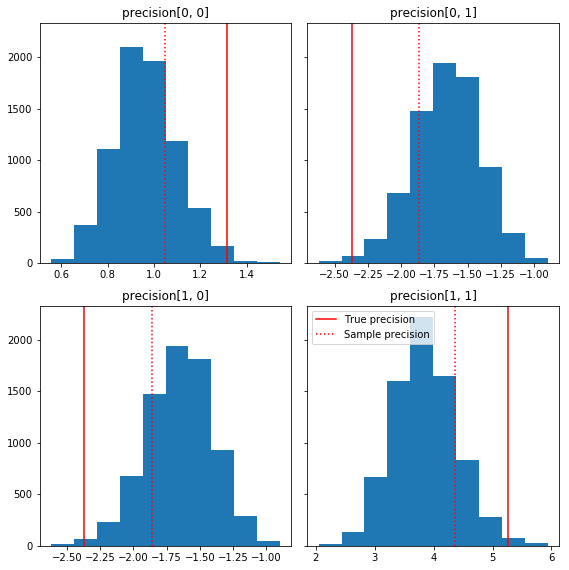

In [ ]:
fig, axes = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(8, 8)
for i in range(2):
  for j in range(2):
    ax = axes[i, j]
    ax.hist(precision_samples_reshaped[:, i, j])
    ax.axvline(true_precision[i, j], color='red',
               label='True precision')
    ax.axvline(sample_precision[i, j], color='red', linestyle=':',
               label='Sample precision')
    ax.set_title('precision[%d, %d]' % (i, j))
plt.tight_layout()
plt.legend()
plt.show()

一些精度分量对的散点图表明，由于后验的相关结构，真实的后验值并不会像上面边际所示的那样不可靠。

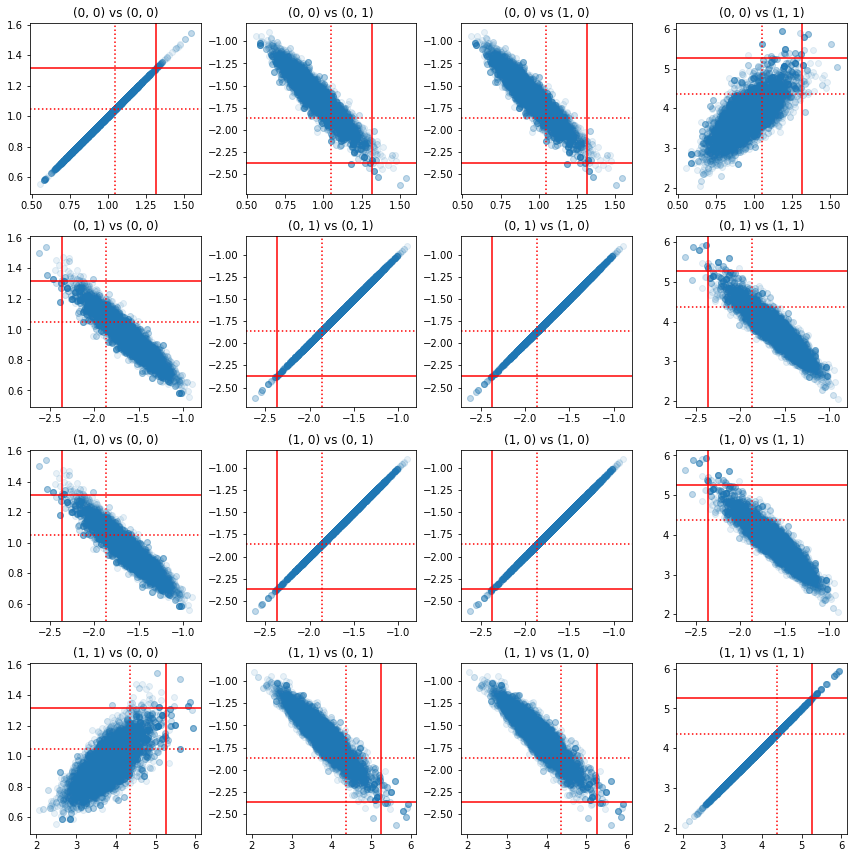

In [ ]:
fig, axes = plt.subplots(4, 4)
fig.set_size_inches(12, 12)
for i1 in range(2):
  for j1 in range(2):
    index1 = 2 * i1 + j1
    for i2 in range(2):
      for j2 in range(2):
        index2 = 2 * i2 + j2
        ax = axes[index1, index2]
        ax.scatter(precision_samples_reshaped[:, i1, j1],
                   precision_samples_reshaped[:, i2, j2], alpha=0.1)
        ax.axvline(true_precision[i1, j1], color='red')
        ax.axhline(true_precision[i2, j2], color='red')
        ax.axvline(sample_precision[i1, j1], color='red', linestyle=':')
        ax.axhline(sample_precision[i2, j2], color='red', linestyle=':')
        ax.set_title('(%d, %d) vs (%d, %d)' % (i1, j1, i2, j2))
plt.tight_layout()
plt.show()

# 版本 4：更简单的约束参数采样

双射函数使精度矩阵采样变得简单，但是在来回转换无约束表示方面则需要大量的手动转换。有更简单的方法！

### TransformedTransitionKernel

`TransformedTransitionKernel` 可简化这一过程。它可以封装您的采样器并处理所有转换。它将可以将无约束参数值映射到约束参数值的双射函数列表作为参数。所以这里我们需要上面使用的 `precision_to_unconstrained` 双射函数的逆函数。我们可以只使用 `tfb.Invert(precision_to_unconstrained)`，但这将涉及对逆函数求逆（TensorFlow 的智能程度不足以将 `tf.Invert(tf.Invert())` 简化为 `tf.Identity())`，所以我们改为编写一个新的双射函数。

### 约束双射函数

In [ ]:
# The bijector we need for the TransformedTransitionKernel is the inverse of
# the one we used above
unconstrained_to_precision = tfb.Chain([
    # step 3: take the product of Cholesky factors
    tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS),
    # step 2: exponentiate the diagonals    
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    # step 1: map a vector to a lower triangular matrix
    tfb.FillTriangular(validate_args=VALIDATE_ARGS),
])

In [ ]:
# quick sanity check
m = [[1., 2.], [2., 8.]]
m_inv = unconstrained_to_precision.inverse(m).numpy()
m_fwd = unconstrained_to_precision.forward(m_inv).numpy()

print('m:\n', m)
print('unconstrained_to_precision.inverse(m):\n', m_inv)
print('forward(unconstrained_to_precision.inverse(m)):\n', m_fwd)

m:
 [[1.0, 2.0], [2.0, 8.0]]
unconstrained_to_precision.inverse(m):
 [0.6931472 2.        0.       ]
forward(unconstrained_to_precision.inverse(m)):
 [[1. 2.]
 [2. 8.]]


## 使用 TransformedTransitionKernel 采样

借助 `TransformedTransitionKernel`，我们便不再需要对参数进行手动转换。我们的初始值和我们的样本都是精度矩阵；我们只需要将无约束双射函数传递给内核，它就会处理所有转换。

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik(my_data)

  # Tuning acceptance rates:
  dtype = np.float32
  num_burnin_iter = 3000
  num_warmup_iter = int(0.8 * num_burnin_iter) 
  num_chain_iter = 2500

  # Set the target average acceptance ratio for the HMC as suggested by
  # Beskos et al. (2013):
  # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
  target_accept_rate = 0.651

  # Initialize the HMC sampler.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

  ttk = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstrained_to_precision)

  # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
  # of Andrieu and Thoms (2008):
  # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=ttk,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

  states = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values,
      kernel=adapted_kernel,
      trace_fn=None,
      parallel_iterations=1)
  # transform samples back to their constrained form
  return states

precision_samples  = sample()

### 检查收敛

$\hat{R}$ 收敛检查看起来不错！

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0013582 1.0019467]
 [1.0019467 1.0011805]]


### 与分析后验对比

让我们再次对照检查分析后验。

In [ ]:
# The output samples have shape [n_steps, n_chains, 2, 2]
# Flatten them to [n_steps * n_chains, 2, 2] via reshape:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])

In [ ]:
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Mean of samples:
 [[ 0.96687526 -1.6552585 ]
 [-1.6552585   3.867676  ]]


In [ ]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435492 0.25050813]
 [0.25050813 0.53903675]]
Standard deviation of samples:
 [[0.13329624 0.24913791]
 [0.24913791 0.53983927]]


# 优化

现在，所需全部功能都可以正常运行了，让我们做一个更优化的版本。速度对于此例并不重要，但一旦矩阵变大，一些优化就会产生很大改善。

我们可以实现的一项重大速度改进是就 Cholesky 分解进行重参数化。原因是我们的数据似然函数需要协方差和精度矩阵。矩阵求逆十分耗费算力（$n \times n$ 矩阵为 $O(n^3)$），如果我们就协方差或精度矩阵进行参数化，则需要求逆以获得逆参数。

提醒一下，实数、正定、对称矩阵 $M$ 可以分解为 $M = L L^T$ 形式的乘积，其中矩阵 $L$ 是下三角矩阵且具有正对角线。给定 $M$ 的 Cholesky 分解，我们可以更高效地得到 $M$（下三角矩阵和上三角矩阵的乘积）和 $M^{-1}$（通过回代）。Cholesky 分解计算本身消耗的算力不低，但如果我们就 Cholesky 因子进行参数化，只需计算初始参数值的 Choleksy 分解即可。


## 使用协方差矩阵的 Cholesky 分解

TFP 具有多元正态分布的一个版本 [MultivariateNormalTriL](https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL)，它就协方差矩阵的 Cholesky 因子进行了参数化。因此，如果我们就协方差矩阵的 Cholesky 因子进行参数化，我们可以高效地计算数据对数似然。挑战在于能否以类似的效率计算先验对数似然。

要是有一个可以处理样本的 Cholesky 因子的逆威沙特分布版本，那我们就大功告成了。唉，我们并没有（不过，团队竭诚欢迎大家提交代码！）。作为替代方案，我们可以使用威沙特分布的一个版本，将样本的 Cholesky 因子与双射函数链共同使用。

目前，我们缺少一些现成的双射函数来真正地提高效率，但我想将这个过程作为一项练习展示，同时作为展现 TFP 双射函数能力的实用说明。

### 基于 Cholesky 因子进行运算的威沙特分布

`Wishart` 分布具有一个实用的标志 `input_output_cholesky`，用于指定输入和输出矩阵应为 Cholesky 因子。与使用完整矩阵相比，使用 Cholesky 因子效率更高且更具数值优势，这就是其可取之处。有关标志语义的很重要的一点：它仅仅指示应改变分布的输入和输出的表示法，但*并非*表示完全重参数化分布，这将涉及对 `log_prob()` 函数执行雅可比校正。实际上，我们希望进行此项完全重参数化，所以我们将自行构建分布。

In [ ]:
# An optimized Wishart distribution that has been transformed to operate on
# Cholesky factors instead of full matrices.  Note that we gain a modest
# additional speedup by specifying the Cholesky factor of the scale matrix
# (i.e. by passing in the scale_tril parameter instead of scale).

class CholeskyWishart(tfd.TransformedDistribution):
  """Wishart distribution reparameterized to use Cholesky factors."""
  def __init__(self,
      df,
      scale_tril,
      validate_args=False,
      allow_nan_stats=True,
      name='CholeskyWishart'):
    # Wishart has a bunch of methods that we want to support but not
    # implement.  We'll subclass TransformedDistribution here to take care of
    # those.  We'll override the few for which speed is critical and implement
    # them with a separate Wishart for which input_output_cholesky=True
    super(CholeskyWishart, self).__init__(
        distribution=tfd.WishartTriL(
            df=df,
            scale_tril=scale_tril,
            input_output_cholesky=False,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats),
        bijector=tfb.Invert(tfb.CholeskyOuterProduct()),
        validate_args=validate_args,
        name=name
    )
    # Here's the Cholesky distribution we'll use for log_prob() and sample()
    self.cholesky = tfd.WishartTriL(
        df=df,
        scale_tril=scale_tril,
        input_output_cholesky=True,
        validate_args=validate_args,
        allow_nan_stats=allow_nan_stats)
    
  def _log_prob(self, x):
    return (self.cholesky.log_prob(x) +
            self.bijector.inverse_log_det_jacobian(x, event_ndims=2))

  def _sample_n(self, n, seed=None):
    return self.cholesky._sample_n(n, seed)

In [ ]:
# some checks
PRIOR_SCALE_CHOLESKY = np.linalg.cholesky(PRIOR_SCALE)

@tf.function(autograph=False)
def compute_log_prob(m):
  w_transformed = tfd.TransformedDistribution(
      tfd.WishartTriL(df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY),
      bijector=tfb.Invert(tfb.CholeskyOuterProduct()))
  w_optimized = CholeskyWishart(
      df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY)
  log_prob_transformed = w_transformed.log_prob(m)
  log_prob_optimized = w_optimized.log_prob(m)
  return log_prob_transformed, log_prob_optimized

for matrix in [np.eye(2, dtype=np.float32),
               np.array([[1., 0.], [2., 8.]], dtype=np.float32)]:
  log_prob_transformed, log_prob_optimized = [
      t.numpy() for t in compute_log_prob(matrix)]
  print('Transformed Wishart:', log_prob_transformed)
  print('Optimized Wishart', log_prob_optimized)

Transformed Wishart: -0.84889317
Optimized Wishart -0.84889317
Transformed Wishart: -99.269455
Optimized Wishart -99.269455


### 构建逆威沙特分布

我们将协方差矩阵 $C$ 分解为 $C = L L^T$，其中 $L$ 是下三角矩阵且具有正对角线。我们想知道给定 $C \sim W^{-1}(\nu, V)$，其中 $W^{-1}$ 为逆威沙特分布时 $L$ 的概率。

逆威沙特分布具有此性质：如果 $C \sim W^{-1}(\nu, V)$，则精度矩阵 $C^{-1} \sim W(\nu, V^{-1})$。因此，我们可以通过将威沙特分布作为参数的 `TransformedDistribution` 以及将精度矩阵的 Cholesky 因子映射到其逆函数的 Cholesky 因子的双射函数来求得 $L$ 的概率。

通过 $C^{-1}$ 的 Cholesky 因子求 $L$ 的一种直接（但不是超级高效）的方法是通过倒推来逆转 Cholesky 因子，然后使用这些逆转因子构成协方差矩阵，随后进行 Cholesky 分解。

设 Cholesky 分解 $C^{-1} = M M^T$。$M$ 是下三角矩阵，因此我们可以使用 `MatrixInverseTriL` 双射函数对其求逆。

使用 $M^{-1}$ 构成 $C$ 有点棘手：$C = (M M^T)^{-1} = M^{-T}M^{-1} = M^{-T} (M^{-T})^T$。$M$ 是下三角矩阵，所以 $M^{-1}$ 也将是下三角矩阵，而 $M^{-T}$ 将是上三角矩阵。`CholeskyOuterProduct()` 双射函数仅适用于下三角矩阵，所以我们不能用它来使用 $M^{-T}$ 构成 $C$。我们的解决方法是使用转置矩阵行和列的双射函数链。

幸运的是，`CholeskyToInvCholesky` 双射函数中封装了此逻辑！

### 组合所有部分

In [ ]:
# verify that the bijector works
m = np.array([[1., 0.], [2., 8.]], dtype=np.float32)
c_inv = m.dot(m.T)
c = np.linalg.inv(c_inv)
c_chol = np.linalg.cholesky(c)
wishart_cholesky_to_iw_cholesky = tfb.CholeskyToInvCholesky()
w_fwd = wishart_cholesky_to_iw_cholesky.forward(m).numpy()

print('numpy =\n', c_chol)
print('bijector =\n', w_fwd)

numpy =
 [[ 1.0307764   0.        ]
 [-0.03031695  0.12126781]]
bijector =
 [[ 1.0307764   0.        ]
 [-0.03031695  0.12126781]]


### 我们的最终分布

我们对 Cholesky 因子的逆威沙特分布运算如下：


In [ ]:
inverse_wishart_cholesky = tfd.TransformedDistribution(
    distribution=CholeskyWishart(
        df=PRIOR_DF,
        scale_tril=np.linalg.cholesky(np.linalg.inv(PRIOR_SCALE))),
    bijector=tfb.CholeskyToInvCholesky())

我们已经得到了逆威沙特分布，但速度较慢，因为我们必须在双射函数中进行 Cholesky 分解。让我们回到精度矩阵参数化，看看在那里能做哪些优化。

# 最终 (!) 版本：使用精度矩阵的 Cholesky 分解

另一种方法是使用精度矩阵的 Cholesky 因子。这里先验似然函数很容易计算，但数据对数似然函数需要更多的工作，因为 TFP 没有按精度参数化的多元正态版本。

### 优化的先验对数似然

我们使用上文中构建的 `CholeskyWishart` 分布来构建先验。


In [ ]:
# Our new prior.
PRIOR_SCALE_CHOLESKY = np.linalg.cholesky(PRIOR_SCALE)

def log_lik_prior_cholesky(precisions_cholesky):
  rv_precision = CholeskyWishart(
      df=PRIOR_DF,
      scale_tril=PRIOR_SCALE_CHOLESKY,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)
  return rv_precision.log_prob(precisions_cholesky)

In [ ]:
# Check against the slower TF implementation and the NumPy implementation.
# Note that when comparing to NumPy, we need to add in the Jacobian correction.
precisions = [np.eye(2, dtype=np.float32),
              true_precision]
precisions_cholesky = np.stack([np.linalg.cholesky(m) for m in precisions])
precisions = np.stack(precisions)
lik_tf = log_lik_prior_cholesky(precisions_cholesky).numpy()
lik_tf_slow = tfd.TransformedDistribution(
    distribution=tfd.WishartTriL(
        df=PRIOR_DF, scale_tril=tf.linalg.cholesky(PRIOR_SCALE)),
    bijector=tfb.Invert(tfb.CholeskyOuterProduct())).log_prob(
    precisions_cholesky).numpy()
corrections = tfb.Invert(tfb.CholeskyOuterProduct()).inverse_log_det_jacobian(
    precisions_cholesky, event_ndims=2).numpy()
n = precisions.shape[0]

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]) + corrections[i])
  print('tensorflow slow:', lik_tf_slow[i])
  print('tensorflow fast:', lik_tf[i])

0
numpy: -0.8488930160357633
tensorflow slow: -0.84889317
tensorflow fast: -0.84889317
1
numpy: -7.442875031036973
tensorflow slow: -7.442877
tensorflow fast: -7.442876


### 优化的数据对数似然

我们可以使用 TFP 的双射函数来构建我们自己的多元正态版本。核心思想如下：

假设我有一个列向量 $X$，其元素是 $N(0, 1)$ 的 iid 样本。可得 $\text{mean}(X) = 0$ 和 $\text{cov}(X) = I$

现在设 $Y = AX + b$。可得 $\text{mean}(Y) = b$ 和 $\text{cov}(Y) = A A^T$

因此，我们可以使用针对 $A A^T = C$ 下的 iid 标准正态样本的向量应用仿射变换 $Ax+b$ 来制作均值为 $b$、协方差为 $C$ 的向量。$C$ 的 Cholesky 分解具有所需的性质。但是，还有其他解决方案。

设 $P = C^{-1}$，并设 $P$ 的 Cholesky 分解为 $B$，即 $B B^T = P$。现在

$P^{-1} = (B B^T)^{-1} = B^{-T} B^{-1} = B^{-T} (B^{-T})^T$

因此，获得我们所需均值和协方差的另一种方法是使用仿射变换 $Y=B^{-T}X + b$。

我们的方法（由[此笔记本](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb)提供）：

1. 使用 `tfd.Independent()` 将一批一维 `Normal` 随机变量组合成一个多维随机变量。`Independent()` 的 `reinterpreted_batch_ndims` 参数指定应重新解释为事件维度的批次维数。在我们的案例中，我们创建了一个长度为 2 的一维批次，我们将其转换为长度为 2 的一维事件，因此 `reinterpreted_batch_ndims=1`。
2. 应用双射函数以添加所需的协方差：`tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=precision_cholesky, adjoint=True))`。请注意，上面我们将 iid 正态随机变量乘以精度矩阵 $(B^{-T}X)$ 的 Cholesky 因子的逆的转置。`tfb.Invert` 负责对 $B$ 求逆，`adjoint=True` 标志执行转置。
3. 应用双射函数来添加所需的偏移量：`tfb.Shift(shift=shift)`。请注意，我们必须将偏移作为与初始逆仿射变换分开的单独步骤执行，否则会将逆缩放应用于偏移（因为 $y=Ax+b$ 的逆函数为 $x=A^{-1}y - A^{-1}b$）。


In [ ]:
class MVNPrecisionCholesky(tfd.TransformedDistribution):
  """Multivariate normal parameterized by loc and Cholesky precision matrix."""

  def __init__(self, loc, precision_cholesky, name=None):
    super(MVNPrecisionCholesky, self).__init__(
        distribution=tfd.Independent(
            tfd.Normal(loc=tf.zeros_like(loc),
                       scale=tf.ones_like(loc)),
            reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=precision_cholesky,
                                  adjoint=True)),
        ]),
        name=name)

In [ ]:
@tf.function(autograph=False)
def log_lik_data_cholesky(precisions_cholesky, replicated_data):
  n = tf.shape(precisions_cholesky)[0]  # number of precision matrices
  rv_data = MVNPrecisionCholesky(
      loc=tf.zeros([n, 2]),
      precision_cholesky=precisions_cholesky)
  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [ ]:
# check against the numpy implementation
true_precision_cholesky = np.linalg.cholesky(true_precision)
precisions = [np.eye(2, dtype=np.float32), true_precision]
precisions_cholesky = np.stack([np.linalg.cholesky(m) for m in precisions])
precisions = np.stack(precisions)
n = precisions_cholesky.shape[0]
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
lik_tf = log_lik_data_cholesky(precisions_cholesky, replicated_data).numpy()

for i in range(n):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.81824


### 组合对数似然函数

现在，我们将我们的先验和数据对数似然函数组合在一个闭包中。

In [ ]:
def get_log_lik_cholesky(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  @tf.function(autograph=False)
  def _log_lik_cholesky(precisions_cholesky):
    return (log_lik_data_cholesky(precisions_cholesky, replicated_data) +
            log_lik_prior_cholesky(precisions_cholesky))

  return _log_lik_cholesky

### 约束双射函数

我们的样本被约束为有效的 Cholesky 因子，这意味着它们必须是具有正对角线的下三角矩阵。`TransformedTransitionKernel` 需要一个双射函数，以将无约束张量映射到/自具有所需约束的张量。我们已经从双射函数的逆函数中移除 Cholesky 分解，这样可以提高速度。

In [ ]:
unconstrained_to_precision_cholesky = tfb.Chain([
    # step 2: exponentiate the diagonals    
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    # step 1: expand the vector to a lower triangular matrix
    tfb.FillTriangular(validate_args=VALIDATE_ARGS),
])

In [ ]:
# some checks
inv = unconstrained_to_precision_cholesky.inverse(precisions_cholesky).numpy()
fwd = unconstrained_to_precision_cholesky.forward(inv).numpy()
print('precisions_cholesky:\n', precisions_cholesky)
print('\ninv:\n', inv)
print('\nfwd(inv):\n', fwd)

precisions_cholesky:
 [[[ 1.         0.       ]
  [ 0.         1.       ]]

 [[ 1.1470785  0.       ]
  [-2.0647411  1.0000004]]]

inv:
 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 3.5762781e-07 -2.0647411e+00  1.3721828e-01]]

fwd(inv):
 [[[ 1.         0.       ]
  [ 0.         1.       ]]

 [[ 1.1470785  0.       ]
  [-2.0647411  1.0000004]]]


### 初始值

我们生成初始值的张量。我们使用 Cholesky 因子，因此生成一些 Cholesky 因子初始值。

In [ ]:
# The number of chains is determined by the shape of the initial values.
# Here we'll generate 3 chains, so we'll need a tensor of 3 initial values.
N_CHAINS = 3

np.random.seed(123)

initial_values_cholesky = []
for i in range(N_CHAINS):
  initial_values_cholesky.append(np.array(
      [[0.5 + np.random.uniform(), 0.0],
       [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
      dtype=np.float32))
initial_values_cholesky = np.stack(initial_values_cholesky)

### 采样

我们使用 `TransformedTransitionKernel` 对 N_CHAINS 链进行采样。

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_cholesky(my_data)

  # Tuning acceptance rates:
  dtype = np.float32
  num_burnin_iter = 3000
  num_warmup_iter = int(0.8 * num_burnin_iter) 
  num_chain_iter = 2500

  # Set the target average acceptance ratio for the HMC as suggested by
  # Beskos et al. (2013):
  # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
  target_accept_rate = 0.651

  # Initialize the HMC sampler.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

  ttk = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstrained_to_precision_cholesky)

  # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
  # of Andrieu and Thoms (2008):
  # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=ttk,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

  states = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values,
      kernel=adapted_kernel,
      trace_fn=None,
      parallel_iterations=1)
  # transform samples back to their constrained form
  samples = tf.linalg.matmul(states, states, transpose_b=True)
  return samples

precision_samples = sample()

### 收敛检查

快速收敛检查看起来不错：

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0013583 1.0019467]
 [1.0019467 1.0011804]]


### 将结果与分析后验对比

In [ ]:
# The output samples have shape [n_steps, n_chains, 2, 2]
# Flatten them to [n_steps * n_chains, 2, 2] via reshape:
precision_samples_reshaped = np.reshape(precision_samples, newshape=[-1, 2, 2])

同样，样本均值和标准差与分析后验的均值和标准差相符。

In [ ]:
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Mean of samples:
 [[ 0.9668749 -1.6552604]
 [-1.6552604  3.8676758]]


In [ ]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435492 0.25050813]
 [0.25050813 0.53903675]]
Standard deviation of samples:
 [[0.13329637 0.24913797]
 [0.24913797 0.53983945]]


好了，大功告成！我们优化的采样器已经可以正常运行了。